<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-2" data-toc-modified-id="Part-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 2</a></span></li><li><span><a href="#Linear-Classifier" data-toc-modified-id="Linear-Classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Classifier</a></span></li><li><span><a href="#Question-3:-10-fold-cross-validation" data-toc-modified-id="Question-3:-10-fold-cross-validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 3: 10-fold cross validation</a></span></li><li><span><a href="#Generating-models-and-measuring-performances" data-toc-modified-id="Generating-models-and-measuring-performances-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generating models and measuring performances</a></span></li><li><span><a href="#Bar-Charts-of-metrics-(Precision,-Recall,-F1-score)" data-toc-modified-id="Bar-Charts-of-metrics-(Precision,-Recall,-F1-score)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bar Charts of metrics (Precision, Recall, F1-score)</a></span></li><li><span><a href="#ROC-Curve-for-every-model-using-out-of-folds-samples" data-toc-modified-id="ROC-Curve-for-every-model-using-out-of-folds-samples-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ROC Curve for every model using out-of-folds samples</a></span></li><li><span><a href="#4.-Visualization-tool" data-toc-modified-id="4.-Visualization-tool-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>4. Visualization tool</a></span></li><li><span><a href="#Save-environment" data-toc-modified-id="Save-environment-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save environment</a></span></li><li><span><a href="#Multi-Layer-perceptron" data-toc-modified-id="Multi-Layer-perceptron-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Multi Layer perceptron</a></span></li><li><span><a href="#Question-3:-10-fold-cross-validation" data-toc-modified-id="Question-3:-10-fold-cross-validation-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Question 3: 10-fold cross validation</a></span></li><li><span><a href="#Bar-Charts-of-metrics-(Precision,-Recall,-F1-score)" data-toc-modified-id="Bar-Charts-of-metrics-(Precision,-Recall,-F1-score)-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Bar Charts of metrics (Precision, Recall, F1-score)</a></span></li><li><span><a href="#ROC-Curve-for-every-model-using-out-of-folds-samples" data-toc-modified-id="ROC-Curve-for-every-model-using-out-of-folds-samples-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>ROC Curve for every model using out-of-folds samples</a></span></li><li><span><a href="#test-ANN" data-toc-modified-id="test-ANN-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>test ANN</a></span></li></ul></div>

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import sklearn.preprocessing
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense# Neural network
from keras.layers import Activation
from keras.layers import Dropout

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# CONSTANTS
BASE_FILE_PATH = "/content/drive/My Drive/HW/DMML/CW/Dataset"
Y_TRAIN_ONE_VS_ALL_BASENAME =  "y_train_smpl_{}.csv"
SEED = 42
TEST_SIZE = 0.33
NUM_CLASSES = 10
DISCRETIZATION_BINS_NUMBER = 10
NUM_OF_FIELDS_TO_KEEP = 10
NUM_FIELDS = 10
NUM_FOLDS = 10
NUM_OF_TENS_OF_FIELDS_TO_TRAIN = 200
IMAGE_SHAPE = (48, 48)
CLASSES = {
    0: "speed_limit_60",
    1: "speed_limit_80",
    2: "speed_limit_80_lifted",
    3: "right of way at crossing",
    4: "right of way in general",
    5: "give way",
    6: "stop",
    7: "no speed limit general",
    8: "turn right down",
    9: "turn left down"
}

In [3]:
data = pd.read_csv("x_train_gr_smpl.csv")
ground_truth = pd.read_csv("y_train_smpl.csv")
ground_truth.columns=["prediction"]
df = pd.concat([data, ground_truth], axis=1)
X, y = data, ground_truth

In [4]:
Y_ONE_VS_ALL = {
    
}
# loading all one_vs_rest ground-truth
for i in CLASSES.keys():
    tmp_gt = pd.read_csv(Y_TRAIN_ONE_VS_ALL_BASENAME.format(i))
    Y_ONE_VS_ALL[i] = tmp_gt

#### Part 2
#### Linear Classifier

#### Question 3: 10-fold cross validation

Using the provided training data sets, and the 10-fold cross validation, run the classifier, and note its accuracy for varying learning parameters provided by Weka (or your other tool of choice). Record all your findings and explain them. Make sure you understand and can explainlogically the meaningof the confusion matrix, as well as the information containedin the “Detailed Accuracy” field: TP Rate, FP Rate, Precision, Recall, F Measure, ROC Area.

In [5]:
Linear_models = {
    "LinearDiscriminantAnalysis": {
        "base_class": LinearDiscriminantAnalysis,
        "models":[],
        "out_of_folds_prediction":{ # in this field, we concatenate all the test instances and results from the 10 folds
            "x":[],
            "y_pred":[],
            "y_true":[],
            "scores":[] # this contains the probabilities associated to the real class of the test instances
          }
    }, # J48 is also known as C4.5 but scikit-learn only implements the CART algorithm, an evolution of the C4.5
    "LogisticRegression": {
        "base_class": LogisticRegression,
        "models":[],
        "out_of_folds_prediction":{
            "x":[],
            "y_pred":[],
            "y_true":[],
            "scores":[]
        }
    }
}

#### Generating models and measuring performances

In [6]:
# matrix of stats where each line is one training run on a given model
# The measures are precision, recall, f1-score, support. We will make one bar chart per measure
# columns are : fold_number, measure_name, measure_val, model, class
stats_1 = []

skf_1  = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

In [7]:
for i, (train_idx, test_idx) in enumerate(skf_1.split(X, y)):

    n_img_train = len(train_idx)
    
    print("Running Fold", i+1, "/", NUM_FOLDS, "on ",n_img_train, " images")

    splitted_X_train = X.iloc[train_idx, :]
    splitted_y_train = y.iloc[train_idx, :]

    splitted_X_test = X.iloc[test_idx, :]
    splitted_y_test = y.iloc[test_idx, :]
    
    # looping over every model, training them and storing their trained model in an array
    for model_key in Linear_models.keys():
        print("\tTraining model ", model_key)

        # initiate an instance of the model class
        model = Linear_models[model_key]["base_class"]()

        Linear_models[model_key]["models"].append(model.fit(splitted_X_train, np.ravel(splitted_y_train)))
        
        print("\tTesting model  ", model_key)
        predicted_test = model.predict(splitted_X_test)
        probas = model.predict_proba(splitted_X_test)
        acc = metrics.accuracy_score(splitted_y_test, predicted_test)
        print("\t\t acc:", acc)
        #probas_of_actual_class = [probas[idx] for probas,idx in zip(probas,np.ravel(splitted_y_test).T)]
        
        Linear_models[model_key]["out_of_folds_prediction"]["x"].extend(splitted_X_test)
        Linear_models[model_key]["out_of_folds_prediction"]["y_true"].extend(splitted_y_test.to_numpy().T.flatten())
        Linear_models[model_key]["out_of_folds_prediction"]["y_pred"].extend(predicted_test)
        Linear_models[model_key]["out_of_folds_prediction"]["scores"].extend(probas)
        
        # print test results
        report = metrics.classification_report(splitted_y_test, predicted_test, output_dict=True)
        # keys of report are the labels (i.e the 10 panel classes here)
        # {'label 1': {'precision':0.5,
        #      'recall':1.0,
        #      'f1-score':0.67,
        #      'support':1},
        # 'label 2': { ... },
        #   ...
        # }
        # keys of the report are : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'accuracy', 'macro avg', 'weighted avg']
        # we want to only loop over the class keys
        for class_key in list(report.keys())[:len(CLASSES.keys())]:
          for measure_key in report[class_key].keys():
            # supports simply gives the number of samples from the class in question
            if (measure_key != "support"):
              # columns are : fold_number, measure_name, measure_val, model_name, class
              #print(report[class_key][measure_key], type(report[class_key][measure_key]), report[class_key])
              stats_1.append(
                  [i, measure_key, float(report[class_key][measure_key]), model_key, class_key]
              )

    
    print('-----------------------\n-----------------------')

Running Fold 1 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8672985781990521
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9360189573459715
-----------------------
-----------------------
Running Fold 2 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8799368088467614
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9470774091627172
-----------------------
-----------------------
Running Fold 3 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8562401263823065
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9257503949447078
-----------------------
-----------------------
Running Fold 4 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.868088467614534
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9478672985781991
-----------------------
-----------------------
Running Fold 5 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8467614533965245
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.919431279620853
-----------------------
-----------------------
Running Fold 6 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8609794628751974
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9249605055292259
-----------------------
-----------------------
Running Fold 7 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8562401263823065
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9360189573459715
-----------------------
-----------------------
Running Fold 8 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8712480252764613
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9368088467614534
-----------------------
-----------------------
Running Fold 9 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8775671406003159
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9502369668246445
-----------------------
-----------------------
Running Fold 10 / 10 on  11394  images
	Training model  LinearDiscriminantAnalysis
	Testing model   LinearDiscriminantAnalysis
		 acc: 0.8704581358609794
	Training model  LogisticRegression


C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Testing model   LogisticRegression
		 acc: 0.9352290679304898
-----------------------
-----------------------


#### Bar Charts of metrics (Precision, Recall, F1-score)

Now that we have trained our models, we will be able to print a bar charts for each measure (hence 3 plots). In the x-axis, we will put the class+model, and on the y-axis the performance for the given measure.

Text(0.5, 1.0, 'Precision measure')

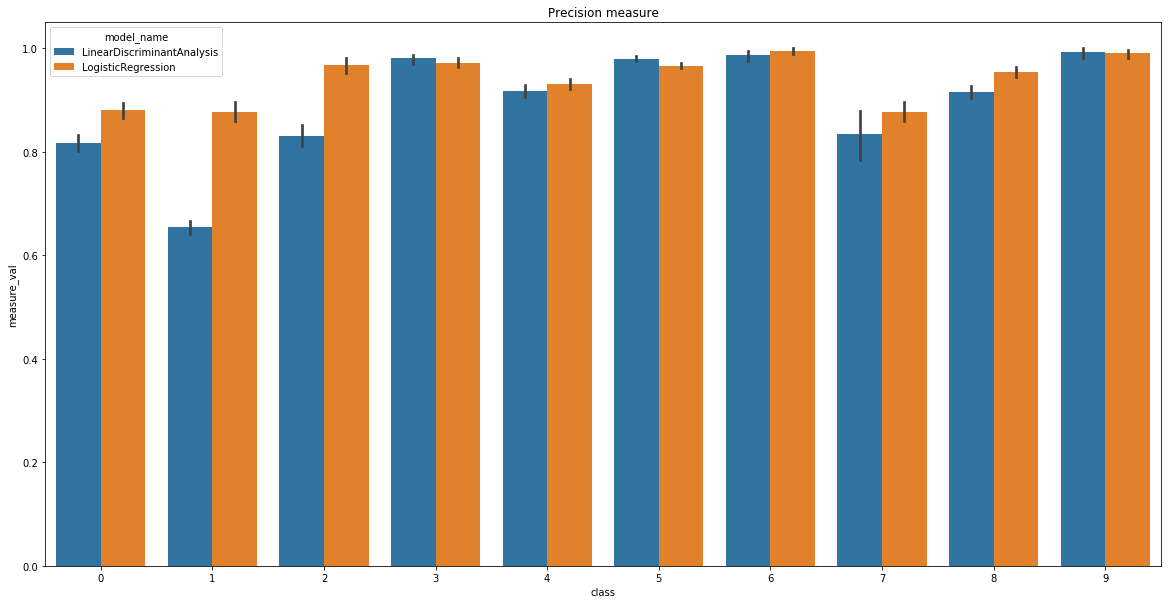

In [8]:
df = pd.DataFrame(np.array(stats_1))

df.columns = ["fold_number", "measure_name", "measure_val", "model_name", "class"]

df["measure_val"] = pd.to_numeric(df.measure_val, errors='coerce')

plt.figure(figsize=(20, 10))
ax = sns.barplot(x="class", y="measure_val", hue="model_name", data=df[df["measure_name"] == "precision"])
ax.set_title("Precision measure")

Text(0.5, 1.0, 'Recall measure')

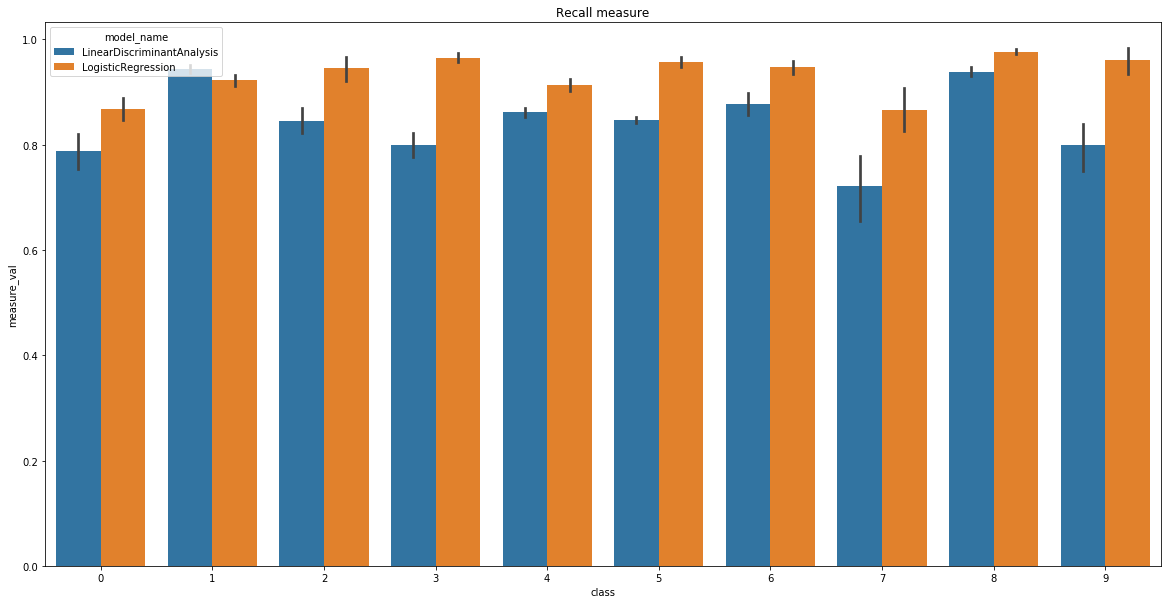

In [9]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="class", y="measure_val", hue="model_name", data=df[df["measure_name"] == "recall"])
ax.set_title("Recall measure")

Text(0.5, 1.0, 'F1 score measure')

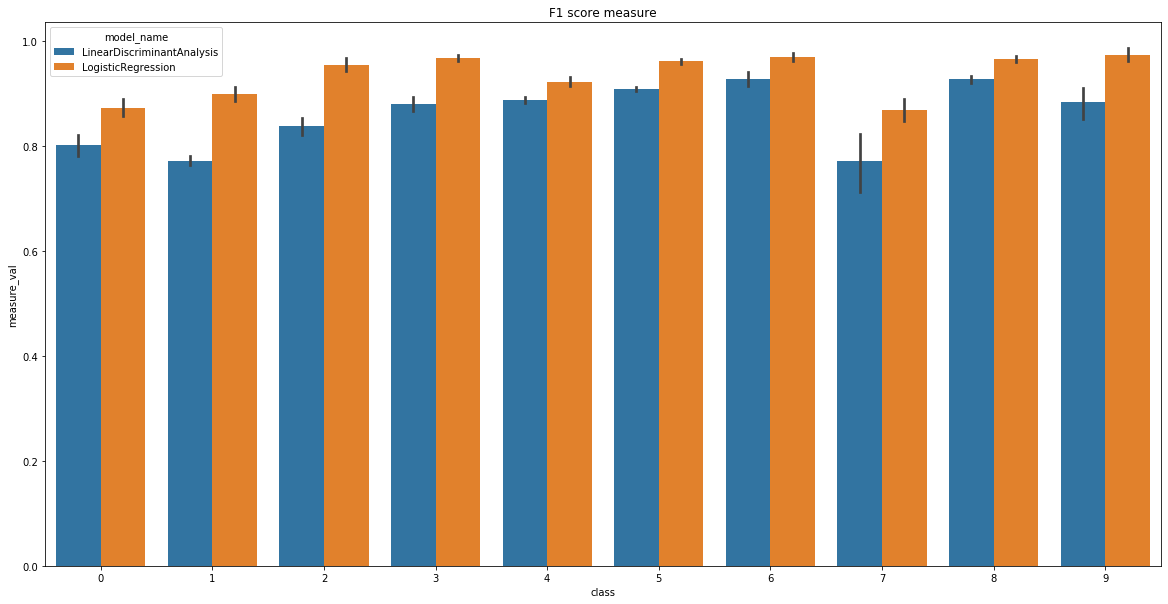

In [10]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="class", y="measure_val", hue="model_name", data=df[df["measure_name"] == "f1-score"])
ax.set_title("F1 score measure")

#### ROC Curve for every model using out-of-folds samples

Using the out-of-folds prediction we collected earlier, we will plot the ROC Curve.

In [11]:
def plot_roc_curve(fpr, tpr, roc_auc, ax, class_number):
  lw = 2
  ax.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(f'ROC of class {class_number}')
  ax.legend(loc="lower right")


(12660, 10)
[0 0 0 1 0 0 0 0 0 0]


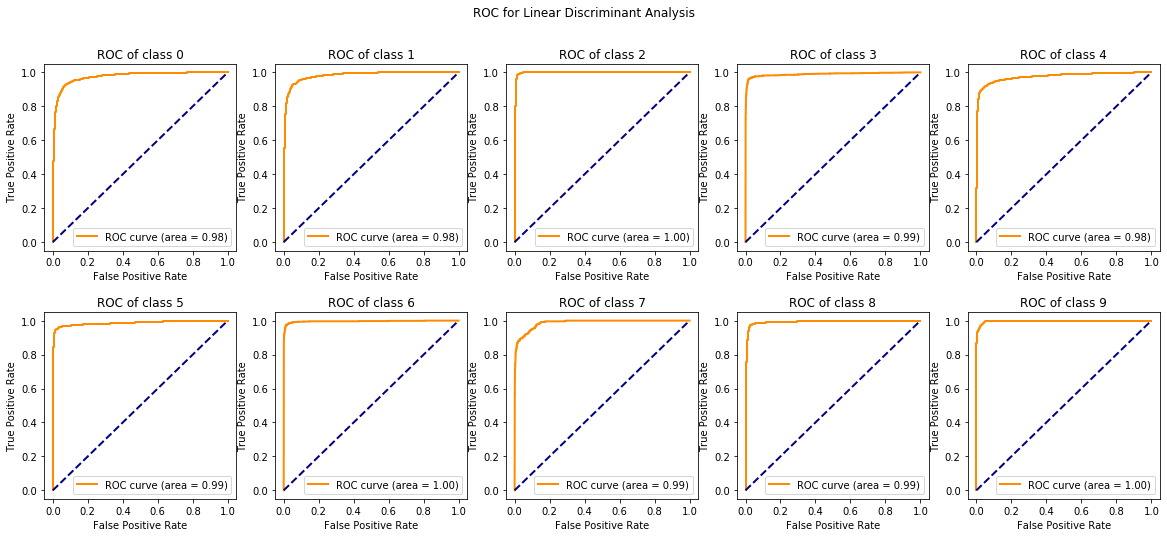

In [33]:
scores = np.array(Linear_models["LinearDiscriminantAnalysis"]["out_of_folds_prediction"]["scores"])
y_bin = sklearn.preprocessing.label_binarize(Linear_models["LinearDiscriminantAnalysis"]["out_of_folds_prediction"]["y_true"], classes=list(CLASSES.keys()))

fig, axs = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(20, 8)
fig.suptitle("ROC for Linear Discriminant Analysis")
fig.subplots_adjust(hspace=0.33)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(list(CLASSES.keys()))):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_bin[:, i], scores[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plot_roc_curve(fpr[i], tpr[i], roc_auc[i], axs[int(i/5), i%5], i)

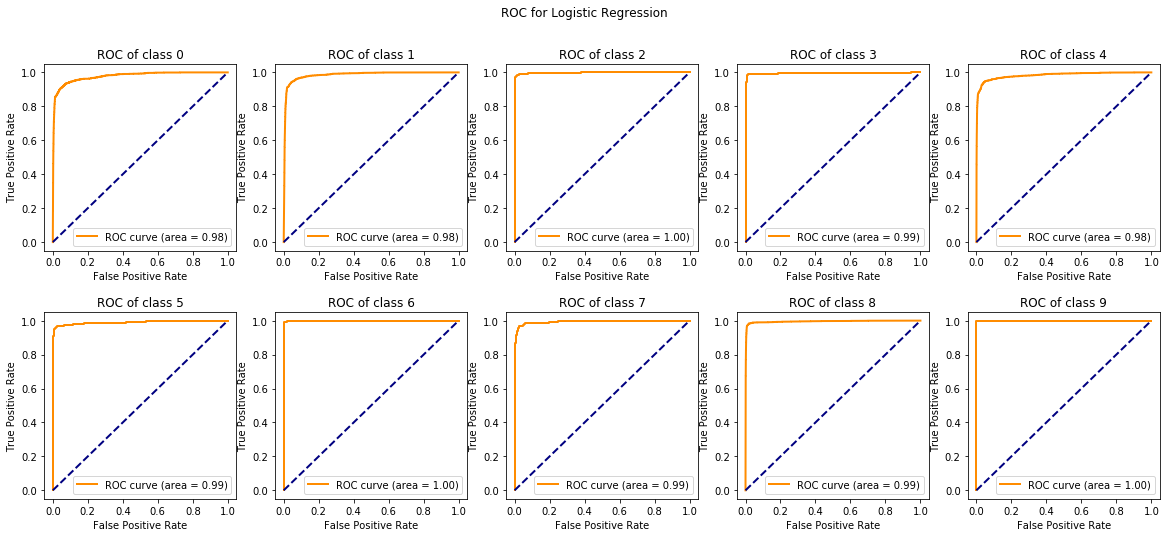

In [39]:
scores = np.array(Linear_models["LogisticRegression"]["out_of_folds_prediction"]["scores"])
y_bin = sklearn.preprocessing.label_binarize(Linear_models["LogisticRegression"]["out_of_folds_prediction"]["y_true"], classes=list(CLASSES.keys()))

fig, axs = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(20, 8)
fig.suptitle("ROC for Logistic Regression")
fig.subplots_adjust(hspace=0.33)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(list(CLASSES.keys()))):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_bin[:, i], scores[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plot_roc_curve(fpr[i], tpr[i], roc_auc[i], axs[int(i/5), i%5], i)


#### 4. Visualization tool

#### Save environment

In [14]:
import dill
dill.dump_session('notebook_env150.db')
#dill.load_session('notebook_env.db')

#### Multi Layer perceptron


#### Question 3: 10-fold cross validation

Using the provided training data sets, and the 10-fold cross validation, run the classifier, and note its accuracy for varying learning parameters provided by Weka (or your other tool of choice). Record all your findings and explain them. Make sure you understand and can explainlogically the meaningof the confusion matrix, as well as the information containedin the “Detailed Accuracy” field: TP Rate, FP Rate, Precision, Recall, F Measure, ROC Area.

In [84]:
Ann_models = {
    "ANN_1": {
        "base_class": Sequential,
        "layers": 3,
        "neurons":[512,512,10],
        "dropout":0.2,
        "activation_function": ['relu','relu','softmax'],
        "batch_size" : 128,
        "epochs":20,
        "verbose":2,
        "models":[],
        "out_of_folds_prediction":{ # in this field, we concatenate all the test instances and results from the 10 folds
            "x":[],
            "y_pred":[],
            "y_true":[],
            "scores":[] # this contains the probabilities associated to the real class of the test instances
          }
    }, 
    "ANN_2": {
        "base_class": Sequential,
        "layers": 4,
        "neurons":[512,512,250,10],
        "dropout":0.2,
        "activation_function": ['relu','relu','relu','softmax'],
        "batch_size" : 128,
        "epochs":20,
        "verbose":2,
        "models":[],
        "out_of_folds_prediction":{
            "x":[],
            "y_pred":[],
            "y_true":[],
            "scores":[]
        }
    }
}

In [85]:
# matrix of stats where each line is one training run on a given model
# The measures are precision, recall, f1-score, support. We will make one bar chart per measure
# columns are : fold_number, measure_name, measure_val, model, class
stats_2 = []

skf_2 = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

In [86]:
for i, (train_idx, test_idx) in enumerate(skf_2.split(X, y)):

    n_img_train = len(train_idx)
    
    print("Running Fold", i+1, "/", NUM_FOLDS, "on ",n_img_train, " images")
    
    #st=StandardScaler()
    #X_st=st.fit_transform(X)
    
    mapper = DataFrameMapper([(X.columns, StandardScaler())])
    scaled_features = mapper.fit_transform(X.copy(), 4)
    X_st = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
    
    #mapper = DataFrameMapper([(y.columns, OneHotEncoder())])
    #scaled_features = mapper.fit_transform(y.copy(), 4)
    #y_ohe = pd.DataFrame(scaled_features, index=y.index, columns=y.columns)
    
    
    #ohe = OneHotEncoder()
    #y_ohe = ohe.fit_transform(y).toarray()
    
    y_ohe=pd.get_dummies(y["prediction"])
    
    splitted_X_train = X_st.iloc[train_idx, :]
    splitted_y_train = y_ohe.iloc[train_idx, :]

    splitted_X_test = X_st.iloc[test_idx, :]
    splitted_y_test = y_ohe.iloc[test_idx, :]
    splitted_y_test_nd=y.iloc[test_idx, :]
    
    # looping over every model, training them and storing their trained model in an array
    for model_key in Ann_models.keys():
        print("\tTraining model ", model_key)

        # initiate an instance of the model class
        model = Ann_models[model_key]["base_class"]()
        model.add(Dense(Ann_models[model_key]["neurons"][0], input_shape=(np.shape(splitted_X_train)[-1],)))
        model.add(Activation(Ann_models[model_key]["activation_function"][0]))                            
        model.add(Dropout(Ann_models[model_key]["dropout"]))
        
        
        for layer in range (1,Ann_models[model_key]["layers"]-1):
            #print(layer)
            model.add(Dense(Ann_models[model_key]["neurons"][layer]))
            model.add(Activation(Ann_models[model_key]["activation_function"][layer]))
            model.add(Dropout(Ann_models[model_key]["dropout"]))
        
        #print([Ann_models[model_key]["layers"]])
        model.add(Dense(Ann_models[model_key]["neurons"][Ann_models[model_key]["layers"]-1]))
        model.add(Activation(Ann_models[model_key]["activation_function"][Ann_models[model_key]["layers"]-1]))    
        
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
        
        #Ann_models[model_key]["models"].append(model.fit(splitted_X_train, np.ravel(splitted_y_train)))
        Ann_models[model_key]["models"].append(model.fit(splitted_X_train, splitted_y_train,batch_size=Ann_models[model_key]["batch_size"], epochs=Ann_models[model_key]["epochs"],verbose=Ann_models[model_key]["verbose"],validation_data=(splitted_X_test, splitted_y_test)))
        
        
        print("\tTesting model  ", model_key)
        predicted_test = model.predict(splitted_X_test)
        predicted_test=np.around(predicted_test, decimals=0)
        probas = model.predict_proba(splitted_X_test)
        acc = metrics.accuracy_score(splitted_y_test, predicted_test)
        print("\t\t acc:", acc)
        #probas_of_actual_class = [probas[idx] for probas,idx in zip(probas,np.ravel(splitted_y_test).T)]
        
        Ann_models[model_key]["out_of_folds_prediction"]["x"].extend(splitted_X_test)
        Ann_models[model_key]["out_of_folds_prediction"]["y_true"].extend(splitted_y_test_nd.to_numpy().T.flatten())
        Ann_models[model_key]["out_of_folds_prediction"]["y_pred"].extend(predicted_test)
        Ann_models[model_key]["out_of_folds_prediction"]["scores"].extend(probas)
        
        # print test results
        report = metrics.classification_report(splitted_y_test, predicted_test, output_dict=True)
        # keys of report are the labels (i.e the 10 panel classes here)
        # {'label 1': {'precision':0.5,
        #      'recall':1.0,
        #      'f1-score':0.67,
        #      'support':1},
        # 'label 2': { ... },
        #   ...
        # }
        # keys of the report are : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'accuracy', 'macro avg', 'weighted avg']
        # we want to only loop over the class keys
        for class_key in list(report.keys())[:len(CLASSES.keys())]:
          for measure_key in report[class_key].keys():
            # supports simply gives the number of samples from the class in question
            if (measure_key != "support"):
              # columns are : fold_number, measure_name, measure_val, model_name, class
              #print(report[class_key][measure_key], type(report[class_key][measure_key]), report[class_key])
              stats_2.append(
                  [i, measure_key, float(report[class_key][measure_key]), model_key, class_key]
              )

    
    print('-----------------------\n-----------------------')

Running Fold 1 / 10 on  11394  images
	Training model  ANN_1
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 5s - loss: 0.9766 - acc: 0.6855 - val_loss: 0.8459 - val_acc: 0.7354
Epoch 2/20
 - 2s - loss: 0.6502 - acc: 0.8063 - val_loss: 0.4583 - val_acc: 0.8294
Epoch 3/20
 - 2s - loss: 0.3481 - acc: 0.8784 - val_loss: 0.3931 - val_acc: 0.8689
Epoch 4/20
 - 2s - loss: 0.2855 - acc: 0.8959 - val_loss: 0.3451 - val_acc: 0.8720
Epoch 5/20
 - 2s - loss: 0.2940 - acc: 0.9024 - val_loss: 0.6512 - val_acc: 0.8183
Epoch 6/20
 - 2s - loss: 0.2658 - acc: 0.9083 - val_loss: 0.2918 - val_acc: 0.8886
Epoch 7/20
 - 2s - loss: 0.2090 - acc: 0.9283 - val_loss: 0.2556 - val_acc: 0.8957
Epoch 8/20
 - 2s - loss: 0.3473 - acc: 0.8959 - val_loss: 0.1829 - val_acc: 0.9273
Epoch 9/20
 - 2s - loss: 0.1799 - acc: 0.9360 - val_loss: 2.1103 - val_acc: 0.7844
Epoch 10/20
 - 2s - loss: 0.7971 - acc: 0.8464 - val_loss: 0.2352 - val_acc: 0.9226
Epoch 11/20
 - 2s - loss: 0.1652 - acc: 0.9404 - val_loss: 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 5s - loss: 1.1621 - acc: 0.6234 - val_loss: 0.4770 - val_acc: 0.8199
Epoch 2/20
 - 2s - loss: 0.5502 - acc: 0.8021 - val_loss: 0.4182 - val_acc: 0.8389
Epoch 3/20
 - 2s - loss: 0.4208 - acc: 0.8469 - val_loss: 0.3194 - val_acc: 0.8736
Epoch 4/20
 - 2s - loss: 0.3163 - acc: 0.8822 - val_loss: 0.8893 - val_acc: 0.8073
Epoch 5/20
 - 2s - loss: 0.5405 - acc: 0.8293 - val_loss: 0.3674 - val_acc: 0.8784
Epoch 6/20
 - 2s - loss: 0.3287 - acc: 0.8768 - val_loss: 0.2763 - val_acc: 0.8815
Epoch 7/20
 - 2s - loss: 0.2599 - acc: 0.9049 - val_loss: 0.2787 - val_acc: 0.8965
Epoch 8/20
 - 2s - loss: 0.2133 - acc: 0.9198 - val_loss: 0.1816 - val_acc: 0.9400
Epoch 9/20
 - 2s - loss: 0.2214 - acc: 0.9206 - val_loss: 0.4635 - val_acc: 0.8807
Epoch 10/20
 - 2s - loss: 0.1878 - acc: 0.9322 - val_loss: 0.2143 - val_acc: 0.9265
Epoch 11/20
 - 2s - loss: 0.1717 - acc: 0.9392 - val_loss: 0.1459 - val_acc: 0.9471
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 6s - loss: 1.1366 - acc: 0.6259 - val_loss: 0.4280 - val_acc: 0.8428
Epoch 2/20
 - 2s - loss: 0.5189 - acc: 0.8124 - val_loss: 0.3221 - val_acc: 0.8776
Epoch 3/20
 - 2s - loss: 0.4205 - acc: 0.8478 - val_loss: 0.4111 - val_acc: 0.8657
Epoch 4/20
 - 2s - loss: 0.3565 - acc: 0.8744 - val_loss: 1.2242 - val_acc: 0.7717
Epoch 5/20
 - 2s - loss: 0.7182 - acc: 0.7717 - val_loss: 0.2904 - val_acc: 0.9044
Epoch 6/20
 - 2s - loss: 0.2730 - acc: 0.8990 - val_loss: 0.4701 - val_acc: 0.8902
Epoch 7/20
 - 2s - loss: 0.5692 - acc: 0.8248 - val_loss: 0.2456 - val_acc: 0.9100
Epoch 8/20
 - 2s - loss: 0.2762 - acc: 0.8999 - val_loss: 0.2444 - val_acc: 0.9186
Epoch 9/20
 - 2s - loss: 0.1967 - acc: 0.9286 - val_loss: 0.1653 - val_acc: 0.9479
Epoch 10/20
 - 2s - loss: 0.1703 - acc: 0.9368 - val_loss: 0.1663 - val_acc: 0.9542
Epoch 11/20
 - 2s - loss: 0.1693 - acc: 0.9362 - val_loss: 0.1250 - val_acc: 0.9660
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 5s - loss: 1.1163 - acc: 0.6339 - val_loss: 1.0032 - val_acc: 0.7030
Epoch 2/20
 - 2s - loss: 0.6364 - acc: 0.7869 - val_loss: 0.3119 - val_acc: 0.8736
Epoch 3/20
 - 2s - loss: 0.3842 - acc: 0.8598 - val_loss: 0.8506 - val_acc: 0.7994
Epoch 4/20
 - 2s - loss: 0.5143 - acc: 0.8286 - val_loss: 0.6928 - val_acc: 0.8088
Epoch 5/20
 - 2s - loss: 0.5005 - acc: 0.8344 - val_loss: 0.2330 - val_acc: 0.9107
Epoch 6/20
 - 2s - loss: 0.2615 - acc: 0.9043 - val_loss: 0.2448 - val_acc: 0.8910
Epoch 7/20
 - 2s - loss: 0.2010 - acc: 0.9256 - val_loss: 0.1761 - val_acc: 0.9273
Epoch 8/20
 - 2s - loss: 0.2016 - acc: 0.9283 - val_loss: 0.1690 - val_acc: 0.9423
Epoch 9/20
 - 2s - loss: 0.2030 - acc: 0.9267 - val_loss: 0.1774 - val_acc: 0.9344
Epoch 10/20
 - 2s - loss: 0.1881 - acc: 0.9330 - val_loss: 0.2003 - val_acc: 0.9242
Epoch 11/20
 - 2s - loss: 0.1792 - acc: 0.9372 - val_loss: 0.1241 - val_acc: 0.9510
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 5s - loss: 1.0701 - acc: 0.6479 - val_loss: 0.5974 - val_acc: 0.8057
Epoch 2/20
 - 2s - loss: 0.6561 - acc: 0.7772 - val_loss: 0.3944 - val_acc: 0.8491
Epoch 3/20
 - 2s - loss: 0.3926 - acc: 0.8542 - val_loss: 0.4395 - val_acc: 0.8404
Epoch 4/20
 - 2s - loss: 0.3372 - acc: 0.8767 - val_loss: 0.2754 - val_acc: 0.9021
Epoch 5/20
 - 2s - loss: 0.2778 - acc: 0.8996 - val_loss: 0.2421 - val_acc: 0.9234
Epoch 6/20
 - 2s - loss: 0.2601 - acc: 0.9076 - val_loss: 0.3067 - val_acc: 0.9060
Epoch 7/20
 - 2s - loss: 0.2428 - acc: 0.9139 - val_loss: 0.3450 - val_acc: 0.8855
Epoch 8/20
 - 2s - loss: 0.2082 - acc: 0.9266 - val_loss: 0.1747 - val_acc: 0.9558
Epoch 9/20
 - 3s - loss: 0.1971 - acc: 0.9321 - val_loss: 0.2375 - val_acc: 0.9171
Epoch 10/20
 - 2s - loss: 0.1794 - acc: 0.9344 - val_loss: 0.1791 - val_acc: 0.9510
Epoch 11/20
 - 2s - loss: 0.1899 - acc: 0.9374 - val_loss: 0.2308 - val_acc: 0.9100
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 6s - loss: 1.1182 - acc: 0.6287 - val_loss: 0.5724 - val_acc: 0.8199
Epoch 2/20
 - 2s - loss: 0.5338 - acc: 0.8131 - val_loss: 0.4830 - val_acc: 0.8262
Epoch 3/20
 - 2s - loss: 0.3891 - acc: 0.8546 - val_loss: 0.2965 - val_acc: 0.9028
Epoch 4/20
 - 2s - loss: 0.3326 - acc: 0.8806 - val_loss: 0.5781 - val_acc: 0.8191
Epoch 5/20
 - 2s - loss: 0.3714 - acc: 0.8685 - val_loss: 0.2842 - val_acc: 0.8910
Epoch 6/20
 - 2s - loss: 0.2801 - acc: 0.9002 - val_loss: 0.2655 - val_acc: 0.8981
Epoch 7/20
 - 2s - loss: 0.2198 - acc: 0.9220 - val_loss: 0.2644 - val_acc: 0.8989
Epoch 8/20
 - 2s - loss: 0.2058 - acc: 0.9246 - val_loss: 0.2765 - val_acc: 0.8886
Epoch 9/20
 - 2s - loss: 0.2111 - acc: 0.9261 - val_loss: 0.2100 - val_acc: 0.9281
Epoch 10/20
 - 2s - loss: 0.1985 - acc: 0.9320 - val_loss: 0.2186 - val_acc: 0.9234
Epoch 11/20
 - 2s - loss: 0.1664 - acc: 0.9406 - val_loss: 0.2195 - val_acc: 0.9139
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 7s - loss: 1.0640 - acc: 0.6454 - val_loss: 0.8211 - val_acc: 0.7717
Epoch 2/20
 - 2s - loss: 0.5091 - acc: 0.8157 - val_loss: 2.5968 - val_acc: 0.6856
Epoch 3/20
 - 2s - loss: 0.8973 - acc: 0.7376 - val_loss: 0.4296 - val_acc: 0.8389
Epoch 4/20
 - 2s - loss: 0.3669 - acc: 0.8657 - val_loss: 0.2341 - val_acc: 0.9321
Epoch 5/20
 - 2s - loss: 0.2771 - acc: 0.8981 - val_loss: 0.2349 - val_acc: 0.8965
Epoch 6/20
 - 2s - loss: 0.2581 - acc: 0.9039 - val_loss: 0.2402 - val_acc: 0.9234
Epoch 7/20
 - 2s - loss: 0.2392 - acc: 0.9123 - val_loss: 0.2579 - val_acc: 0.9013
Epoch 8/20
 - 2s - loss: 0.2499 - acc: 0.9120 - val_loss: 0.6899 - val_acc: 0.8349
Epoch 9/20
 - 2s - loss: 0.3498 - acc: 0.8838 - val_loss: 0.1345 - val_acc: 0.9518
Epoch 10/20
 - 2s - loss: 0.2282 - acc: 0.9200 - val_loss: 0.1535 - val_acc: 0.9550
Epoch 11/20
 - 2s - loss: 0.2105 - acc: 0.9251 - val_loss: 0.1402 - val_acc: 0.9439
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 6s - loss: 1.1438 - acc: 0.6223 - val_loss: 0.7123 - val_acc: 0.7409
Epoch 2/20
 - 2s - loss: 0.7360 - acc: 0.7600 - val_loss: 0.3977 - val_acc: 0.8570
Epoch 3/20
 - 2s - loss: 0.4632 - acc: 0.8390 - val_loss: 0.2949 - val_acc: 0.8942
Epoch 4/20
 - 2s - loss: 0.3233 - acc: 0.8811 - val_loss: 0.2959 - val_acc: 0.9052
Epoch 5/20
 - 2s - loss: 0.3892 - acc: 0.8688 - val_loss: 0.2308 - val_acc: 0.9265
Epoch 6/20
 - 2s - loss: 0.2438 - acc: 0.9098 - val_loss: 0.2092 - val_acc: 0.9336
Epoch 7/20
 - 2s - loss: 0.2007 - acc: 0.9279 - val_loss: 0.2613 - val_acc: 0.8863
Epoch 8/20
 - 2s - loss: 0.2043 - acc: 0.9268 - val_loss: 0.1742 - val_acc: 0.9455
Epoch 9/20
 - 2s - loss: 0.2663 - acc: 0.9147 - val_loss: 0.2181 - val_acc: 0.9186
Epoch 10/20
 - 2s - loss: 0.1788 - acc: 0.9355 - val_loss: 0.1688 - val_acc: 0.9408
Epoch 11/20
 - 2s - loss: 0.1689 - acc: 0.9381 - val_loss: 0.1532 - val_acc: 0.9455
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 6s - loss: 1.0906 - acc: 0.6388 - val_loss: 0.6469 - val_acc: 0.7780
Epoch 2/20
 - 2s - loss: 0.6386 - acc: 0.7823 - val_loss: 0.3340 - val_acc: 0.8807
Epoch 3/20
 - 2s - loss: 0.3835 - acc: 0.8555 - val_loss: 0.2903 - val_acc: 0.8831
Epoch 4/20
 - 2s - loss: 0.3128 - acc: 0.8841 - val_loss: 0.3785 - val_acc: 0.8728
Epoch 5/20
 - 2s - loss: 0.3155 - acc: 0.8851 - val_loss: 0.3900 - val_acc: 0.8594
Epoch 6/20
 - 2s - loss: 0.2602 - acc: 0.9008 - val_loss: 0.2512 - val_acc: 0.9242
Epoch 7/20
 - 2s - loss: 0.2316 - acc: 0.9193 - val_loss: 0.1841 - val_acc: 0.9400
Epoch 8/20
 - 2s - loss: 0.2314 - acc: 0.9197 - val_loss: 2.6848 - val_acc: 0.7172
Epoch 9/20
 - 2s - loss: 0.5119 - acc: 0.8488 - val_loss: 0.2181 - val_acc: 0.9202
Epoch 10/20
 - 2s - loss: 0.1724 - acc: 0.9365 - val_loss: 0.1867 - val_acc: 0.9329
Epoch 11/20
 - 2s - loss: 0.1656 - acc: 0.9394 - val_loss: 0.2199 - val_acc: 0.9258
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 6s - loss: 1.0862 - acc: 0.6477 - val_loss: 0.5740 - val_acc: 0.8002
Epoch 2/20
 - 2s - loss: 0.5176 - acc: 0.8166 - val_loss: 0.6511 - val_acc: 0.7780
Epoch 3/20
 - 2s - loss: 0.5131 - acc: 0.8239 - val_loss: 0.3840 - val_acc: 0.8681
Epoch 4/20
 - 2s - loss: 0.3543 - acc: 0.8705 - val_loss: 0.2731 - val_acc: 0.8957
Epoch 5/20
 - 2s - loss: 0.3021 - acc: 0.8914 - val_loss: 0.2237 - val_acc: 0.9147
Epoch 6/20
 - 2s - loss: 0.2380 - acc: 0.9123 - val_loss: 0.2300 - val_acc: 0.9155
Epoch 7/20
 - 2s - loss: 0.2381 - acc: 0.9170 - val_loss: 0.1737 - val_acc: 0.9329
Epoch 8/20
 - 2s - loss: 0.2099 - acc: 0.9237 - val_loss: 0.2450 - val_acc: 0.9052
Epoch 9/20
 - 2s - loss: 0.2046 - acc: 0.9243 - val_loss: 0.3641 - val_acc: 0.8878
Epoch 10/20
 - 2s - loss: 0.2699 - acc: 0.9071 - val_loss: 0.3183 - val_acc: 0.8886
Epoch 11/20
 - 2s - loss: 0.1985 - acc: 0.9301 - val_loss: 0.1936 - val_acc: 0.9400
Epoch 12/20
 

C:\Users\Clarence\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


	Training model  ANN_2
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
 - 8s - loss: 1.0950 - acc: 0.6407 - val_loss: 0.5705 - val_acc: 0.7812
Epoch 2/20
 - 2s - loss: 0.5704 - acc: 0.8036 - val_loss: 0.5441 - val_acc: 0.8128
Epoch 3/20
 - 2s - loss: 0.4361 - acc: 0.8443 - val_loss: 0.3189 - val_acc: 0.8855
Epoch 4/20
 - 2s - loss: 0.3165 - acc: 0.8817 - val_loss: 0.5520 - val_acc: 0.8444
Epoch 5/20
 - 2s - loss: 0.2997 - acc: 0.8922 - val_loss: 0.2203 - val_acc: 0.9171
Epoch 6/20
 - 2s - loss: 0.2228 - acc: 0.9204 - val_loss: 0.2004 - val_acc: 0.9139
Epoch 7/20
 - 2s - loss: 0.2674 - acc: 0.9054 - val_loss: 0.4755 - val_acc: 0.8610
Epoch 8/20
 - 2s - loss: 0.3127 - acc: 0.8973 - val_loss: 0.2686 - val_acc: 0.9131
Epoch 9/20
 - 2s - loss: 0.1729 - acc: 0.9383 - val_loss: 0.2197 - val_acc: 0.9194
Epoch 10/20
 - 2s - loss: 0.1916 - acc: 0.9322 - val_loss: 0.1339 - val_acc: 0.9447
Epoch 11/20
 - 2s - loss: 0.1720 - acc: 0.9410 - val_loss: 0.1996 - val_acc: 0.9273
Epoch 12/20
 

In [ ]:
import dill
dill.dump_session('notebook_env350.db')
#dill.load_session('notebook_env.db')

#### Bar Charts of metrics (Precision, Recall, F1-score)

Now that we have trained our models, we will be able to print a bar charts for each measure (hence 3 plots). In the x-axis, we will put the class+model, and on the y-axis the performance for the given measure.

Text(0.5, 1.0, 'Precision measure')

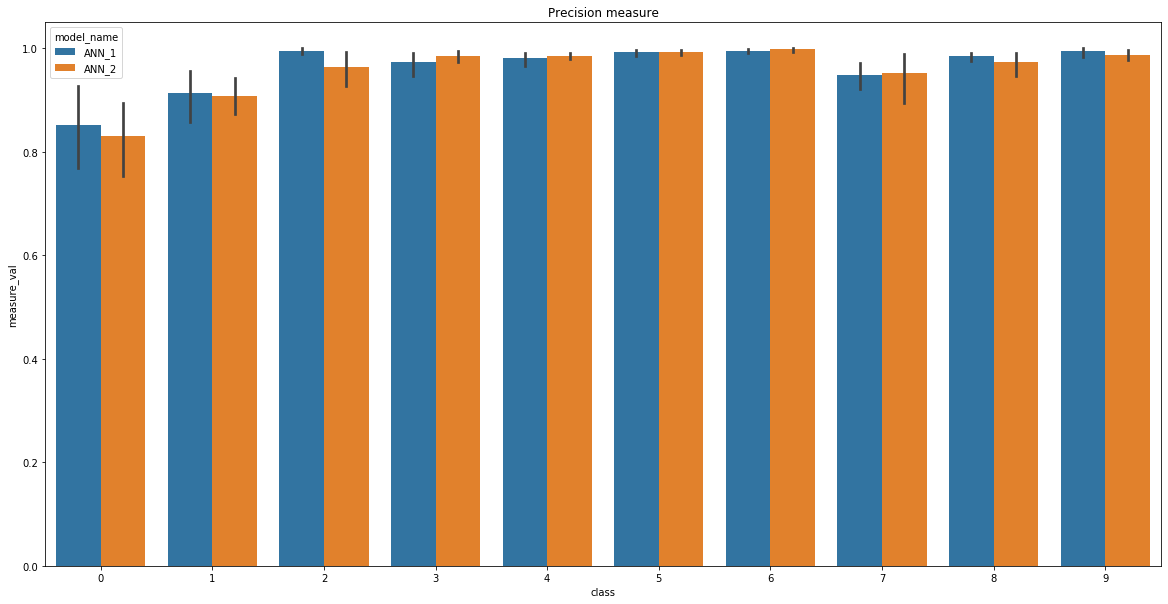

In [87]:
df = pd.DataFrame(np.array(stats_2))

df.columns = ["fold_number", "measure_name", "measure_val", "model_name", "class"]

df["measure_val"] = pd.to_numeric(df.measure_val, errors='coerce')

plt.figure(figsize=(20, 10))
ax = sns.barplot(x="class", y="measure_val", hue="model_name", data=df[df["measure_name"] == "precision"])
ax.set_title("Precision measure")

Text(0.5, 1.0, 'Recall measure')

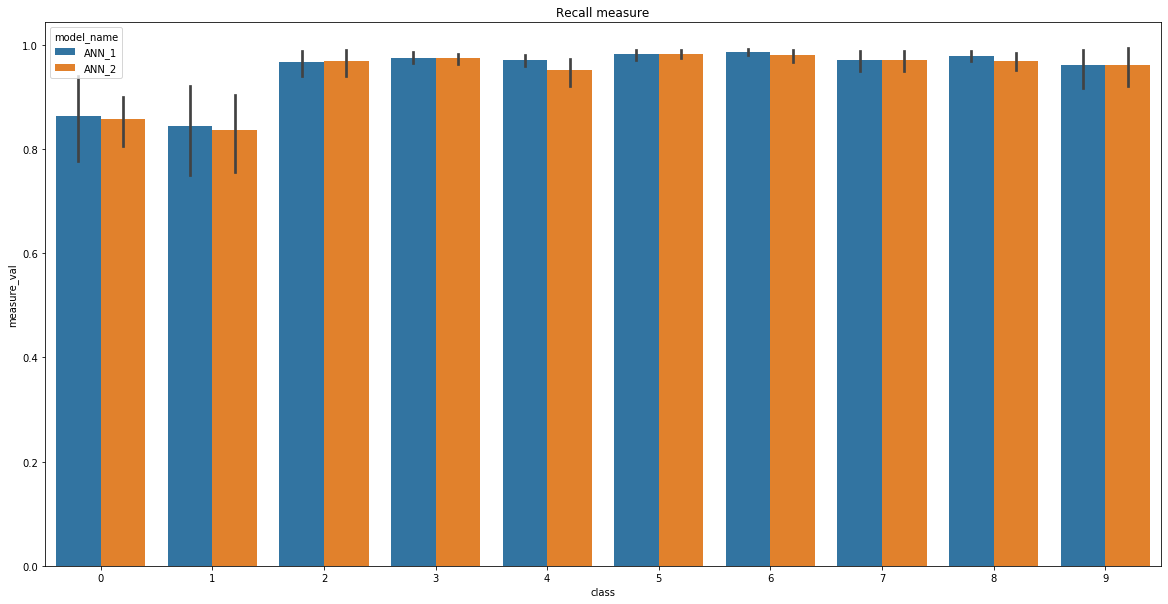

In [88]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="class", y="measure_val", hue="model_name", data=df[df["measure_name"] == "recall"])
ax.set_title("Recall measure")

Text(0.5, 1.0, 'F1 score measure')

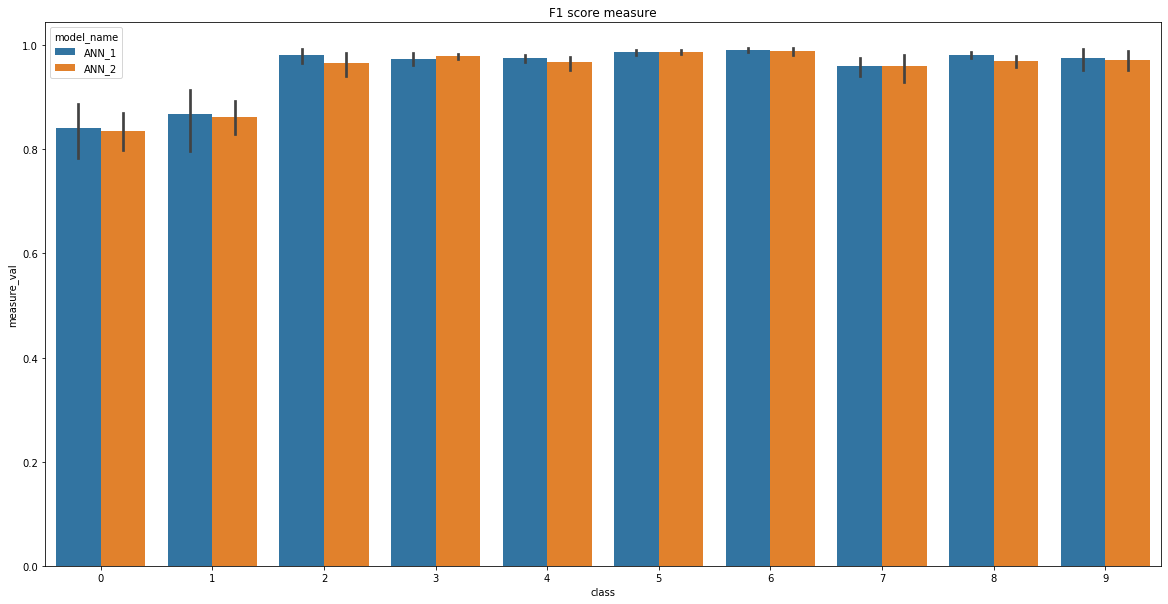

In [89]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="class", y="measure_val", hue="model_name", data=df[df["measure_name"] == "f1-score"])
ax.set_title("F1 score measure")

#### ROC Curve for every model using out-of-folds samples

Using the out-of-folds prediction we collected earlier, we will plot the ROC Curve.

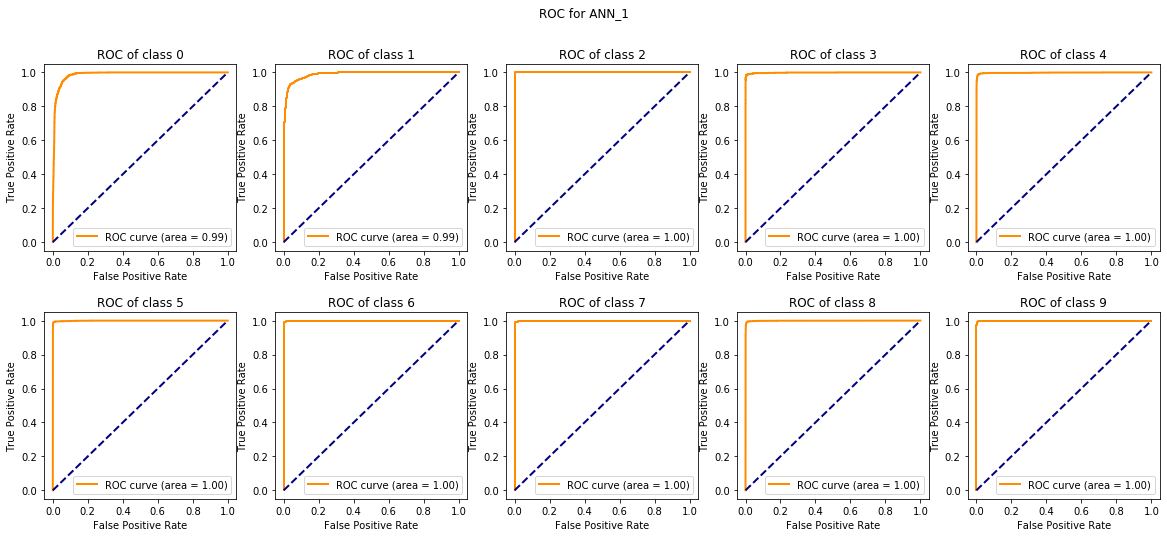

In [92]:
scores = np.array(Ann_models["ANN_1"]["out_of_folds_prediction"]["scores"])
y_bin = sklearn.preprocessing.label_binarize(Ann_models["ANN_1"]["out_of_folds_prediction"]["y_true"], classes=list(CLASSES.keys()))


fig, axs = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(20, 8)
fig.suptitle("ROC for ANN_1")
fig.subplots_adjust(hspace=0.33)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(list(CLASSES.keys()))):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_bin[:, i], scores[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plot_roc_curve(fpr[i], tpr[i], roc_auc[i], axs[int(i/5), i%5], i)

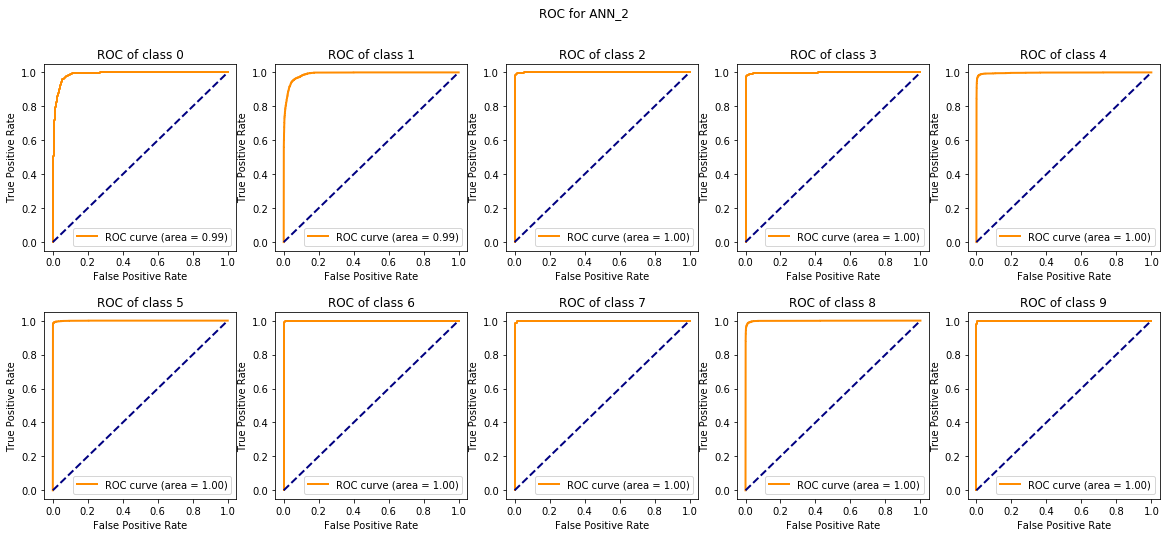

In [93]:
scores = np.array(Ann_models["ANN_2"]["out_of_folds_prediction"]["scores"])
y_bin = sklearn.preprocessing.label_binarize(Ann_models["ANN_2"]["out_of_folds_prediction"]["y_true"], classes=list(CLASSES.keys()))

fig, axs = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(20, 8)
fig.suptitle("ROC for ANN_2")
fig.subplots_adjust(hspace=0.33)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(list(CLASSES.keys()))):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_bin[:, i], scores[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plot_roc_curve(fpr[i], tpr[i], roc_auc[i], axs[int(i/5), i%5], i)


#### test ANN

In [35]:
mapper = DataFrameMapper([(X.columns, StandardScaler())])
scaled_features = mapper.fit_transform(X.copy(), 4)

X_st = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
y_ohe=pd.get_dummies(y["prediction"])

X_train_st, X_test_st, y_train_ohe, y_test_ohe = train_test_split(
    X_st,y_ohe, test_size=TEST_SIZE, random_state=SEED)



model = Sequential()

model.add(Dense(512, input_shape=(np.shape(X_train_st)[-1],)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))



model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history = model.fit(X_train_st, y_train_ohe,batch_size=128, epochs=20,verbose=2,validation_data=(X_test_st, y_test_ohe))
predicted_test = model.predict(X_test_st)
predicted_test=np.around(predicted_test, decimals=0)
acc = metrics.accuracy_score(y_test_ohe, predicted_test)
print("\t\t acc:", acc)


Train on 8482 samples, validate on 4178 samples
Epoch 1/20
 - 3s - loss: 1.2282 - acc: 0.6362 - val_loss: 0.6015 - val_acc: 0.7968
Epoch 2/20
 - 1s - loss: 0.5532 - acc: 0.8062 - val_loss: 0.4193 - val_acc: 0.8427
Epoch 3/20
 - 1s - loss: 0.4009 - acc: 0.8616 - val_loss: 0.3423 - val_acc: 0.8899
Epoch 4/20
 - 1s - loss: 0.3797 - acc: 0.8707 - val_loss: 0.2457 - val_acc: 0.9191
Epoch 5/20
 - 1s - loss: 0.2910 - acc: 0.9004 - val_loss: 0.3056 - val_acc: 0.8901
Epoch 6/20
 - 2s - loss: 0.3052 - acc: 0.8981 - val_loss: 0.2484 - val_acc: 0.9253
Epoch 7/20
 - 2s - loss: 0.2692 - acc: 0.9071 - val_loss: 0.2727 - val_acc: 0.9079
Epoch 8/20
 - 2s - loss: 0.2482 - acc: 0.9161 - val_loss: 0.2336 - val_acc: 0.9313
Epoch 9/20
 - 2s - loss: 0.1977 - acc: 0.9293 - val_loss: 0.1854 - val_acc: 0.9464
Epoch 10/20
 - 1s - loss: 0.2166 - acc: 0.9308 - val_loss: 0.6332 - val_acc: 0.8609
Epoch 11/20
 - 1s - loss: 0.2560 - acc: 0.9179 - val_loss: 0.1556 - val_acc: 0.9540
Epoch 12/20
 - 1s - loss: 0.1524 - ac